# Data Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


from rdkit import Chem
from rdkit.Chem import Descriptors


from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import to_networkx, from_smiles

import os
import random

In [2]:
plt.style.use('ggplot')

In [3]:
def global_seed(seed=2):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
global_seed()

### Dataset

In [5]:
df = pd.read_csv('Data/Lipophilicity.csv')
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [6]:
df.describe()

,exp
count,4200.000000
mean,2.186336
std,1.203004
min,-1.500000
25%,1.410000
50%,2.360000
75%,3.100000
max,4.500000


In [7]:
df['smiles'].nunique()

4200

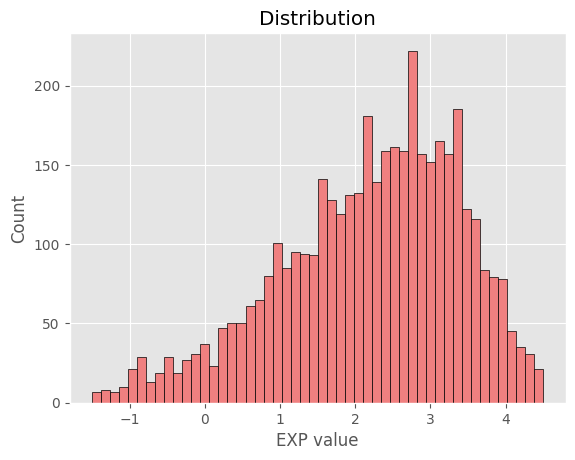

In [8]:
plt.hist(x=df['exp'], bins=50, edgecolor='black', linewidth=0.5, color='lightcoral')
plt.title('Distribution')
plt.xlabel('EXP value')
plt.ylabel('Count')
plt.show()

#### Creating Mol object from smiles representation

In [9]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles', molCol='mol')
df.head()

,CMPD_CHEMBLID,exp,smiles,mol
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...


#### Extracting molecular weight

In [10]:
df['mol_wt'] = df['mol'].apply(Descriptors.MolWt)
df.head()

,CMPD_CHEMBLID,exp,smiles,mol,mol_wt
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...,340.858
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...,494.591
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...,321.829
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...,419.890
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,<rdkit.Chem.rdchem.Mol object at 0x000001DC8F8...,381.480


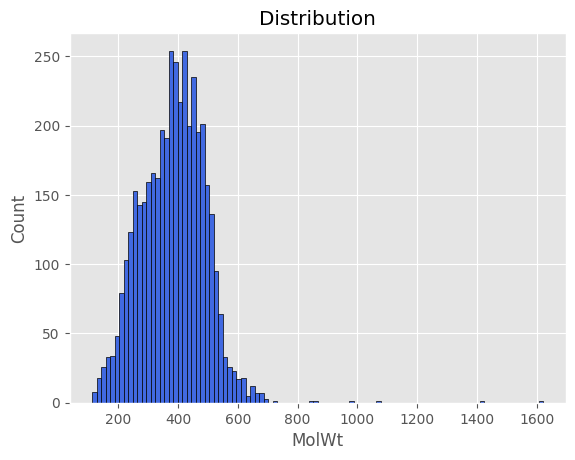

In [11]:
plt.hist(x=df['mol_wt'], bins=100, edgecolor='black', linewidth=0.5, color='royalblue')
plt.title('Distribution')
plt.xlabel('MolWt')
plt.ylabel('Count')
plt.show()

#### Let's take a look at molecules with high molecular weight

In [12]:
import requests

def get_molecule_names(chembl_ids):
    base_url = "https://www.ebi.ac.uk/chembl/api/data/molecule.json"
    
    params = {
        'molecule_chembl_id__in': ','.join(chembl_ids),
        'limit': len(chembl_ids) 
    }

    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json().get('molecules', [])
        return {item['molecule_chembl_id']: item.get('pref_name') for item in data}
    else:
        return {}

In [13]:
high_mol_wt = df.loc[df['mol_wt'] > 700].copy()

# Extract ChEMBL IDs and request molecule names
chembl_ids = high_mol_wt['CMPD_CHEMBLID'].unique().tolist()
mol_name_map = get_molecule_names(chembl_ids)

# Map the results back to the DataFrame
high_mol_wt['mol_name'] = high_mol_wt['CMPD_CHEMBLID'].map(mol_name_map)

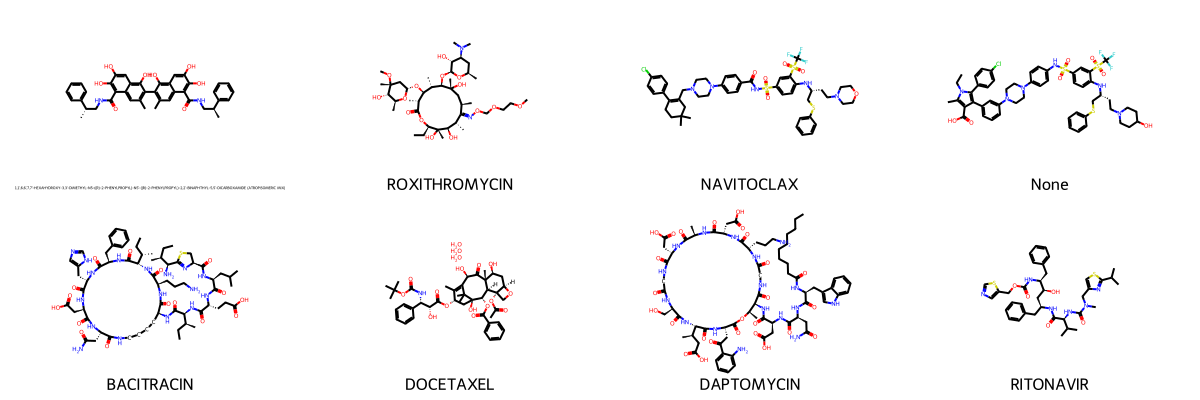

In [14]:

img = Draw.MolsToGridImage(high_mol_wt['mol'], molsPerRow=4, subImgSize=(300, 200), legends=[str(x) for x in high_mol_wt['mol_name']])
img

#### Removing outliers (molecules with high molecular weight)

In [15]:
high_mol_wt_smiles = high_mol_wt['smiles']
df_final = df[~df['smiles'].isin(high_mol_wt_smiles)]
df_final = df_final.reset_index(drop=True)
df_final.shape

(4192, 5)

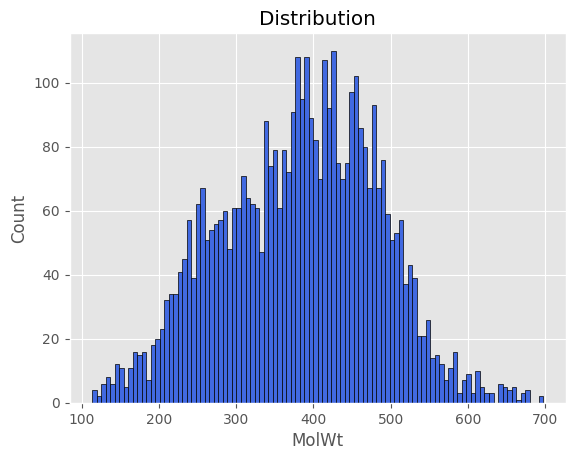

In [16]:
plt.hist(x=df_final['mol_wt'], bins=100, edgecolor='black', linewidth=0.5, color='royalblue')
plt.title('Distribution')
plt.xlabel('MolWt')
plt.ylabel('Count')
plt.show()

### Unique Atoms    

In [17]:
unique_atoms = {}
for mol in df_final['mol']:
    for atom in mol.GetAtoms():
        atom_symbol = atom.GetSymbol()
        if atom_symbol not in unique_atoms:
            unique_atoms[atom_symbol] = 1
        else:
            unique_atoms[atom_symbol] += 1


In [18]:
unique_atoms

{'C': 83065,
 'N': 14505,
 'Cl': 1288,
 'O': 10679,
 'S': 1580,
 'F': 1760,
 'B': 6,
 'Br': 100,
 'P': 3,
 'I': 7,
 'Si': 1,
 'Se': 1}

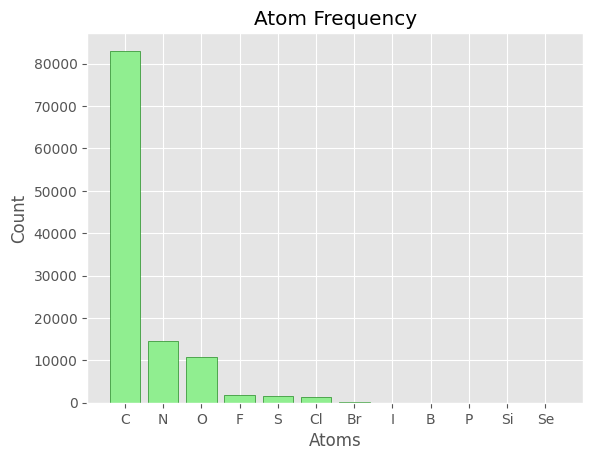

In [19]:
atom_freq = pd.DataFrame(unique_atoms.items(), columns=['Atom', 'Count']).sort_values('Count', ascending=False)
plt.bar(x=atom_freq['Atom'], height=atom_freq['Count'], color='lightgreen', edgecolor='forestgreen')
plt.title('Atom Frequency')
plt.xlabel('Atoms')
plt.ylabel('Count')
plt.show()

In [24]:
df_to_save = df_final[['CMPD_CHEMBLID', 'exp', 'smiles']]
df_to_save.to_csv('Data/Lipophilicity_final.csv', index=None)

## Generating Torch Geometric objects

In [26]:
df = pd.read_csv('Data/Lipophilicity_final.csv')

In [27]:
df.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


#### Quick introduction to torch geometric

In [50]:
# Taking a single molecule smile
smile = df['smiles'][25]
smile

'Clc1ccc(N2CCN(CC2)C(=O)CCCc3ccncc3)c(Cl)c1'

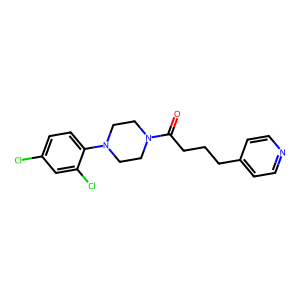

In [51]:
# Drawing the molecule structure
mol = Chem.MolFromSmiles(smile)
mol_img = Draw.MolToImage(mol)
mol_img

In [52]:
# Creating Pytorch Geometric Data using from_smiles() function
# https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.from_smiles
mol_g = from_smiles(smile, with_hydrogen=False)
mol_g

Data(x=[25, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Clc1ccc(N2CCN(CC2)C(=O)CCCc3ccncc3)c(Cl)c1')

In [53]:
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data
type(mol_g)

torch_geometric.data.data.Data

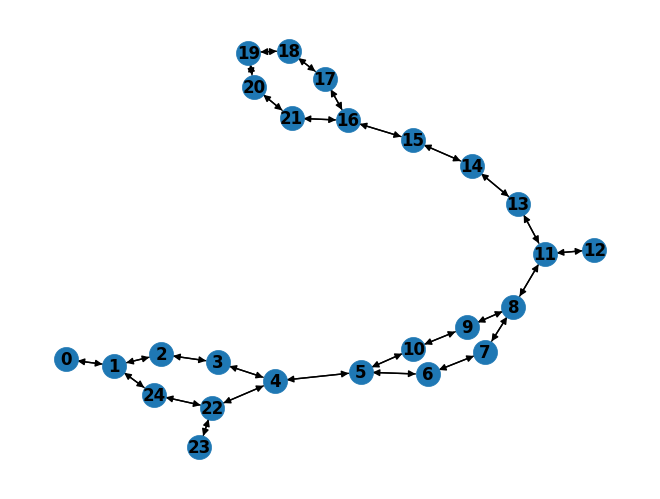

In [ ]:
# Geometric representation of selected molecule
mol_nx = to_networkx(mol_g)
nx.draw(mol_nx, with_labels=True, font_weight='bold')

#### Generating Graphs for the Whole Dataset

In [58]:
# From: https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])
        # For PyG<2.4:
        # self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'Lipophilicity_final.csv'

    @property
    def processed_file_names(self):
        return 'data.dt'

    def download(self):
        # Download to `self.raw_dir`.
        # download_url(url, self.raw_dir)
        pass

    def process(self):
        # Read data into huge `Data` list.

        ############# Added this part ###############
        data_list = []
        for i, smile in enumerate(df_final['smiles']):
          g = from_smiles(smile)
          g.x = g.x.float()
          y = torch.tensor(df_final['exp'][i], dtype=torch.float).view(1, -1)
          g.y = y
          data_list.append(g)
        #############################################

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [59]:
lipo_df = MyOwnDataset(root='Data')

Processing...
Done!


In [61]:
type(lipo_df)

__main__.MyOwnDataset

In [62]:
len(lipo_df)

4192